In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
import scanpy as sc

adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Batch_corrected\Hao_PBMC_Harmony_unscaled.h5ad")
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [4]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4 TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [5]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch\Level1\feature_selection")

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [6]:
features_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T'])

In [7]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,11,6
CD4_T,346,197
CD8_T,22,7
DC,32,15
Mono,19,10
NK,33,17
other,4,2
other_T,59,25


## Build classifiers (K-fold CV)

In [8]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [9]:
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch\Level1\LR_classifiers")

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_Harmony_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: B
[0.9990603617142779, 0.9964339169746907, 0.992536231884058, 0.9944771291363208, 0.9999321223614764, 0.9994666262269852, 0.9939683746272415]
K-fold CV for: CD4_T
[0.9727319131472634, 0.9468857106473794, 0.9468063412849711, 0.9464510609514699, 0.9953286175812742, 0.9867397254133102, 0.9285163489059716]
K-fold CV for: CD8_T
[0.9715326169958173, 0.9358536917985747, 0.8794618139511255, 0.9067434707827629, 0.9886205153200324, 0.9584247973072084, 0.8905902054545336]
K-fold CV for: DC
[0.9983989024479987, 0.9698379467841296, 0.9576481237592415, 0.9636947342121228, 0.9997920456508413, 0.9922089391624521, 0.9629014030520053]
K-fold CV for: Mono
[0.9922603266901533, 0.9793526232469034, 0.9954499081820037, 0.9873322307533771, 0.998171146943335, 0.993200272788231, 0.9818319701674177]
K-fold CV for: NK
[0.992563237332195, 0.9693488788907588, 0.9662455076805492, 0.9677534492349837, 0.9986812522716992, 0.9940306614313101, 0.9635783762837166]
K-fold CV for: other
[0.9917287073438124, 0

In [10]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999060,0.996434,0.992536,0.994477,0.999932,0.999467,0.993968
CD4_T,0.972732,0.946886,0.946806,0.946451,0.995329,0.986740,0.928516
CD8_T,0.971533,0.935854,0.879462,0.906743,0.988621,0.958425,0.890590
DC,0.998399,0.969838,0.957648,0.963695,0.999792,0.992209,0.962901
Mono,0.992260,0.979353,0.995450,0.987332,0.998171,0.993200,0.981832
NK,0.992563,0.969349,0.966246,0.967753,0.998681,0.994031,0.963578
other,0.991729,0.926873,0.659126,0.756311,0.930343,0.782826,0.770412
other_T,0.985714,0.881007,0.762698,0.817384,0.986354,0.885081,0.812385


In [11]:
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_l1.csv')

## Read saved .pkl

## Plot classifier K-fold CV metrics

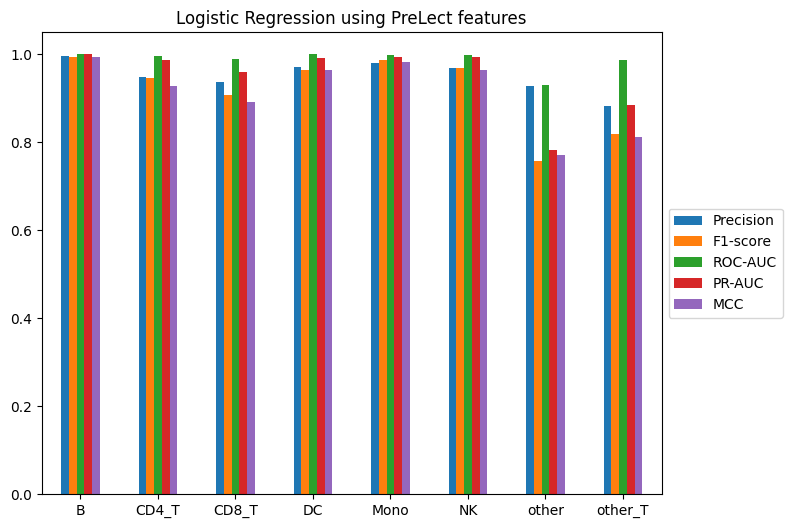

In [13]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=0, figsize=(8,6), title='Logistic Regression using PreLect features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))